
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [97]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV

In [98]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

# Create raget and predictor variables and split
X = ha.drop(columns= "cp")
y = ha["cp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create ct
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [67]:
pipeline_KNN = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', KNeighborsClassifier())
])
# Create grid for tuning
knn_params = {'regressor__n_neighbors': range(1, 21)}
knn_grid = GridSearchCV(pipeline_KNN, knn_params, cv=5, scoring='accuracy')
best_knn = knn_grid.fit(X_train, y_train)

# Best KNN model
print(f"Best KNN parameters: {knn_grid.best_params_}")
print(f"\nBest Accuracy: {knn_grid.best_score_}")

Best KNN parameters: {'regressor__n_neighbors': 11}

Best Accuracy: 0.5784146341463415


In [95]:
# Define pipeline for Decision Tree
pipeline_dt = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', DecisionTreeClassifier(random_state=42))
])

# Create grid for tuning
tree_params = {
    'regressor__max_depth': range(1, 5), 
    'regressor__min_samples_split': range(2, 5),
    'regressor__min_samples_leaf': [1, 2, 4],
                }
tree_grid = GridSearchCV(pipeline_dt, tree_params, cv=5, scoring='f1_weighted')
best_tree = tree_grid.fit(X_train, y_train)

# Best Decision Tree model
print(f"Best Decision Tree parameters: {tree_grid.best_params_}")
print(f"\nBest Weighted F1 Score: {tree_grid.best_score_}")

Best Decision Tree parameters: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}

Best Weighted F1 Score: 0.5190190729562312


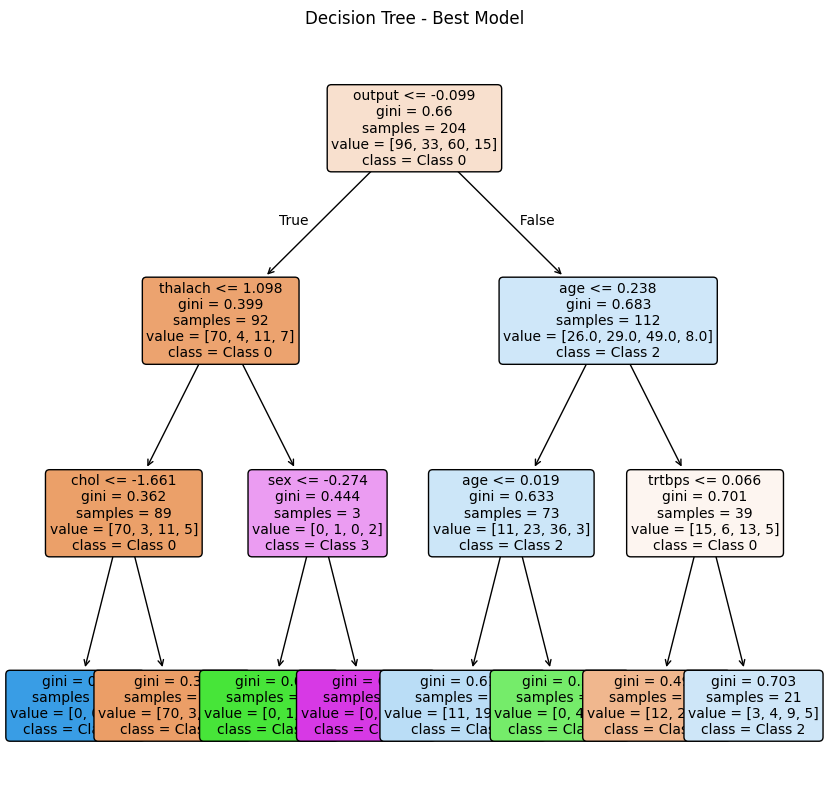

In [96]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the best decision tree model from the pipeline
best_dt_model = best_tree.best_estimator_.named_steps['regressor']

# Plot the decision tree
plt.figure(figsize=(10, 10))  # Adjust size of the plot
plot_tree(best_dt_model, 
          feature_names=X_train.columns,  # Use your feature names here
          class_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'],  # Adjust according to your classes
          filled=True,  # Color the nodes based on the majority class
          rounded=True,  # Rounded corners for a cleaner look
          fontsize=10)
plt.title("Decision Tree - Best Model")
plt.show()

In this decision tree, the model first looks to see if `output` is 0 or 1. From there it will evaluate the next step. If True, then will next look for `thalach` values less than or equal to 1.098; or if false, `age` less than or equal to 0.238 *(recall values are standardized)*. Then the model will continue evaluating different features until it reaches a leaf node and assigns a classification. 

In [70]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pipeline_lda = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'))
])

# Create grid for tuning
lda_params = {
    'regressor__n_components': [1, 2, 3],  # Can be any integer <= min(n_features, n_classes - 1)
    'regressor__tol': [1e-4, 1e-3, 1e-2]  # Tolerance for optimization
}

# Perform grid search
lda_grid = GridSearchCV(pipeline_lda, lda_params, cv=5, scoring='accuracy')
best_lda = lda_grid.fit(X_train, y_train)

# Best LDA model
print(f"Best LDA parameters: {lda_grid.best_params_}")
print(f"\nBest Accuracy: {lda_grid.best_score_}")

Best LDA parameters: {'regressor__n_components': 1, 'regressor__tol': 0.0001}

Best Accuracy: 0.5782926829268293


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [71]:
ha["cp_is_3"] = (ha["cp"] == 3).astype(int)

X = ha.drop(columns= ["cp", "cp_is_3"])
y = ha["cp_is_3"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline_logistic = Pipeline([
    ('preprocessor', ct),
    ('regressor', LogisticRegression(max_iter=1000))
])

# Create grid for tuning
logreg_params = {'regressor__C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='f1')
best_logreg = logreg_grid.fit(X_train, y_train)

print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"\nBest F1 Score (cp = 3): {logreg_grid.best_score_}")

Best Logistic parameters: {'regressor__C': 0.01}

Best F1 Score (cp = 3): 0.0


In [72]:
ha["cp_is_2"] = (ha["cp"] == 2).astype(int)

X = ha.drop(columns= ["cp", "cp_is_3", "cp_is_2"])
y = ha["cp_is_2"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='f1')
best_logreg = logreg_grid.fit(X_train, y_train)

print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"\nBest F1 Score (cp = 2): {logreg_grid.best_score_}")

Best Logistic parameters: {'regressor__C': 1}

Best F1 Score (cp = 2): 0.17435574229691878


In [73]:
ha["cp_is_1"] = (ha["cp"] == 1).astype(int)

X = ha.drop(columns= ["cp", "cp_is_3", "cp_is_2", "cp_is_1"])
y = ha["cp_is_1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='f1')
best_logreg = logreg_grid.fit(X_train, y_train)

print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"\nBest F1 Score (cp = 1): {logreg_grid.best_score_}")

Best Logistic parameters: {'regressor__C': 0.01}

Best F1 Score (cp = 1): 0.0


In [74]:
ha["cp_is_0"] = (ha["cp"] == 0).astype(int)

X = ha.drop(columns= ["cp", "cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"])
y = ha["cp_is_0"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='f1')
best_logreg = logreg_grid.fit(X_train, y_train)

print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"\nBest F1 Score (cp = 0): {logreg_grid.best_score_}")

Best Logistic parameters: {'regressor__C': 0.1}

Best F1 Score (cp = 0): 0.7060485155478736


From our OvR analysis, we found that the approach best distinguished cp levels equal to 0. 

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [81]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha_0_1 = ha[(ha["cp"] == 0) | (ha["cp"] == 1)]

X = ha_0_1.drop(columns= ["cp"])
y = ha_0_1["cp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline_logistic = Pipeline([
    ('preprocessor', ct),
    ('regressor', LogisticRegression(max_iter=1000))
])

# Create grid for tuning
logreg_params = {'regressor__C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='roc_auc')
best_logreg = logreg_grid.fit(X_train, y_train)

print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"\nBest ROC AUC (0-1): {logreg_grid.best_score_}")

Best Logistic parameters: {'regressor__C': 0.1}

Best ROC AUC (0-1): 0.858295739348371


In [82]:
ha_0_2 = ha[(ha["cp"] == 0) | (ha["cp"] == 2)]

X = ha_0_2.drop(columns= ["cp"])
y = ha_0_2["cp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline_logistic = Pipeline([
    ('preprocessor', ct),
    ('regressor', LogisticRegression(max_iter=1000))
])

# Create grid for tuning
logreg_params = {'regressor__C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='roc_auc')
best_logreg = logreg_grid.fit(X_train, y_train)

print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"\nBest ROC AUC (0-2): {logreg_grid.best_score_}")

Best Logistic parameters: {'regressor__C': 100}

Best ROC AUC (0-2): 0.7450877192982456


In [83]:
ha_0_3 = ha[(ha["cp"] == 0) | (ha["cp"] == 3)]

X = ha_0_3.drop(columns= ["cp"])
y = ha_0_3["cp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline_logistic = Pipeline([
    ('preprocessor', ct),
    ('regressor', LogisticRegression(max_iter=1000))
])

# Create grid for tuning
logreg_params = {'regressor__C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='roc_auc')
best_logreg = logreg_grid.fit(X_train, y_train)

print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"\nBest ROC AUC (0-3): {logreg_grid.best_score_}")

Best Logistic parameters: {'regressor__C': 0.1}

Best ROC AUC (0-3): 0.7924561403508772


From our OvO analysis, we found that the approach produced the highest ROC AUC when reducing the data set to only cp values of 0 and 1. 
